In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyTMD.time
from pyTMD.infer_minor_corrections import infer_minor_corrections
from pyTMD.predict_tidal_ts import predict_tidal_ts
from pyTMD.read_tide_model import extract_tidal_constants

<xarray.Dataset>
Dimensions:                        (location: 1, measurement: 140257, prediction: 1402561)
Dimensions without coordinates: location, measurement, prediction
Data variables:
    water_level_observed           (measurement) float64 ...
    time_of_water_level_observed   (measurement) datetime64[ns] ...
    water_level_predicted          (prediction) float64 ...
    time_of_water_level_predicted  (prediction) datetime64[ns] ...
    easting                        (location) float64 ...
    northing                       (location) float64 ...
    latitude                       (location) float64 ...
    longitude                      (location) float64 ...
Attributes:
    title:                     Observed and predicted water level time series...
    summary:                   Hourly observed and six-minute predicted water...
    station:                   9410230
    source:                    Extracted from https://tidesandcurrents.noaa.g...
    Conventions:            

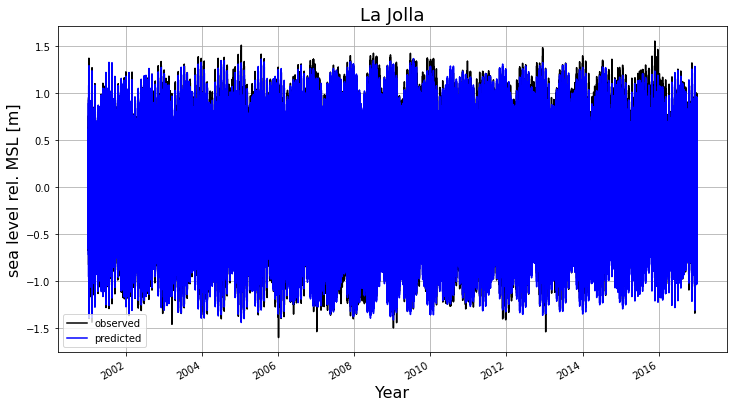

In [2]:
# look at sea level measurements for La Jolla (dataset I am familiar with)
fn ='/Users/bonnieludka/MyBeach/LudkaEtAl2019SciData/water_levels.nc' #filename
dLJ = xr.open_dataset(fn)
print(dLJ)

#lat lon
latLJ = dLJ.latitude.values
lonLJ = dLJ.longitude.values 
print('latitude:'+str(latLJ))
print('longitude:'+str(lonLJ)) 

# LAT and LON for tide model
LON = lonLJ[0].item()
LON %= 360
print(LON)
LAT = latLJ[0].item()

print('latitude for TPXO tide model:'+str(LAT))
print('longitude for TPXO tide model:'+str(LON)) 

NAVD88toMSL = .77 #https://tidesandcurrents.noaa.gov/datums.html?datum=MLLW&units=1&epoch=0&id=9410230&name=La+Jolla&state=CA

# Data array of observed La Jolla sea level (relative MSL)
da_LJ_sl_obs_hourly = xr.DataArray(dLJ.water_level_observed.values - NAVD88toMSL, 
                         dims=['date'],
                         coords={'date':dLJ.time_of_water_level_observed.values})

# Data array of predicted La Jolla sea level (relative MSL)
da_LJ_sl_pred_6min = xr.DataArray(dLJ.water_level_predicted.values - NAVD88toMSL,
                         dims=['date'],
                         coords={'date':dLJ.time_of_water_level_predicted.values})

# time step 
print('time variable type:'+str(type(da_LJ_sl_obs_hourly[0].date.values))) #datetime64
stp_LJ_obs = np.nanmean(np.diff(da_LJ_sl_obs_hourly.date))/np.timedelta64(1, 's') 
stp_LJ_pred = np.nanmean(np.diff(da_LJ_sl_pred_6min.date))/np.timedelta64(1, 's') 
print('time step observed (in seconds):'+str(stp_LJ_obs)) 
print('time step predicted (in seconds):'+str(stp_LJ_pred)) 

fig,ax = plt.subplots(figsize=(12, 6))
da_LJ_sl_obs_hourly.plot(color='black',label='observed')
da_LJ_sl_pred_6min.plot(color='blue',label='predicted')
plt.xlabel('Year', fontsize=16)
plt.ylabel('sea level rel. MSL [m]', fontsize=16)
plt.title('La Jolla',fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

In [3]:
# define time period of interest
dts = np.datetime64('2011-01-01')#'2013-08-01')#('2013-08-26')
dte = np.datetime64('2011-02-01')#'2013-09-30')#('2013-09-01')
# extract data from relevant indices in "groundtruth" data 
da_LJ_sl_obs_hourly_short = da_LJ_sl_obs_hourly.sel(date=slice(dts,dte)) 
da_LJ_sl_pred_6min_short = da_LJ_sl_pred_6min.sel(date=slice(dts,dte)) 

In [4]:
# get tide from TPXO atlas v4 model
tide_dir = '/Users/bonnieludka/OneDrive - UC San Diego/SatelliteDerivedBathymetry/analysis/projects/abaco_bight/data/tide'
TIDE_MODEL = 'TPXO9-atlas-v4'

#-- convert from calendar date to days relative to Jan 1, 1992 (48622 MJD) (<- why Jan 1 1992 ??)
#YMD = datetime.date(2013, 8, 1)
# look at functions in pyTMD.time b/c likely a better way to do this
yr_start = dts.astype(object).year #YMD.year
print(yr_start)
mo_start = dts.astype(object).month #YMD.month
print(mo_start)
d_start = dts.astype(object).day #YMD.day
print(d_start)
# how many hours of data I want to grab
days = dte-dts
hrs_later = days.astype('timedelta64[h]')
print(hrs_later)
hours_later = hrs_later.astype(int).item() + 1 #add 1? # convert from numpy.timedelta64 to numpy.int64
print(hours_later)
hours = np.arange(hours_later) 
minutes = hours*60
print(minutes)

print(hours)
print(hours.shape)
print(type(hours))
print(type(hours[0]))
#tide_time_hourly_short = pyTMD.time.convert_calendar_dates(yr_start, mo_start, d_start, hour= hours)
tide_time_hourly_short = pyTMD.time.convert_calendar_dates(yr_start, mo_start, d_start, minute= minutes)
print(tide_time_hourly_short)
print(tide_time_hourly_short.shape)
# seems to work if I google "7883 days after jan 1 1992"... "7943 days after jan 1 1992"

2011
1
1
744 hours
745
[    0    60   120   180   240   300   360   420   480   540   600   660
   720   780   840   900   960  1020  1080  1140  1200  1260  1320  1380
  1440  1500  1560  1620  1680  1740  1800  1860  1920  1980  2040  2100
  2160  2220  2280  2340  2400  2460  2520  2580  2640  2700  2760  2820
  2880  2940  3000  3060  3120  3180  3240  3300  3360  3420  3480  3540
  3600  3660  3720  3780  3840  3900  3960  4020  4080  4140  4200  4260
  4320  4380  4440  4500  4560  4620  4680  4740  4800  4860  4920  4980
  5040  5100  5160  5220  5280  5340  5400  5460  5520  5580  5640  5700
  5760  5820  5880  5940  6000  6060  6120  6180  6240  6300  6360  6420
  6480  6540  6600  6660  6720  6780  6840  6900  6960  7020  7080  7140
  7200  7260  7320  7380  7440  7500  7560  7620  7680  7740  7800  7860
  7920  7980  8040  8100  8160  8220  8280  8340  8400  8460  8520  8580
  8640  8700  8760  8820  8880  8940  9000  9060  9120  9180  9240  9300
  9360  9420  9480  9540  96

In [5]:
model_directory = os.path.join(tide_dir,'TPXO9_atlas_v4')
grid_file = os.path.join(model_directory,'grid_tpxo9_atlas_30_v4')
model_files = ['h_q1_tpxo9_atlas_30_v4','h_o1_tpxo9_atlas_30_v4',
    'h_p1_tpxo9_atlas_30_v4','h_k1_tpxo9_atlas_30_v4',
    'h_n2_tpxo9_atlas_30_v4','h_m2_tpxo9_atlas_30_v4',
    'h_s2_tpxo9_atlas_30_v4','h_k2_tpxo9_atlas_30_v4',
    'h_m4_tpxo9_atlas_30_v4','h_ms4_tpxo9_atlas_30_v4',
    'h_mn4_tpxo9_atlas_30_v4','h_2n2_tpxo9_atlas_30_v4',
    'h_mf_tpxo9_atlas_30_v4','h_mm_tpxo9_atlas_30_v4']
model_file = [os.path.join(model_directory,m) for m in model_files]
model_format = 'OTIS'
EPSG = '4326'
TYPE = 'z'
amp,ph,D,c = extract_tidal_constants(np.array([LON]), np.array([LAT]),
        grid_file, model_file, EPSG, TYPE=TYPE, METHOD='spline',
        EXTRAPOLATE=True, GRID=model_format)
deltat = np.zeros_like(tide_time_hourly_short)

#-- calculate complex phase in radians for Euler's
cph = -1j*ph*np.pi/180.0
#-- calculate constituent oscillation
hc = amp*np.exp(cph)

In [6]:
#-- convert time from MJD to days relative to Jan 1, 1992 (48622 MJD)
#-- predict tidal elevations at time 1 and infer minor corrections
TIDE_LJ_hourly_short = predict_tidal_ts(tide_time_hourly_short, hc, c,
    DELTAT=deltat, CORRECTIONS=model_format)
print(TIDE_LJ_hourly_short.data[:])
print(type(TIDE_LJ_hourly_short.data[:]))
print(TIDE_LJ_hourly_short.data[:].shape)
MINOR_LJ_hourly_short = infer_minor_corrections(tide_time_hourly_short, hc, c,
    DELTAT=deltat, CORRECTIONS=model_format)
print(MINOR_LJ_hourly_short.data[:])
print(type(MINOR_LJ_hourly_short.data[:]))
print(MINOR_LJ_hourly_short.data[:].shape)
TIDE_LJ_hourly_short.data[:] += MINOR_LJ_hourly_short.data[:]
# keep units in meters
print(TIDE_LJ_hourly_short.data[:])
print(type(TIDE_LJ_hourly_short.data[:]))
print(TIDE_LJ_hourly_short.data[:].shape)

print(hours)

[-3.81480907e-01 -7.71808631e-02  1.51584788e-01  2.59712181e-01
  2.39138507e-01  1.19397926e-01 -4.24461648e-02 -1.78587631e-01
 -2.28793927e-01 -1.55959096e-01  4.37923750e-02  3.38126697e-01
  6.63855444e-01  9.40776509e-01  1.09176252e+00  1.06392577e+00
  8.44186981e-01  4.63999643e-01 -8.08208420e-03 -4.83025778e-01
 -8.71808812e-01 -1.10465996e+00 -1.14553998e+00 -9.99677798e-01
 -7.12540935e-01 -3.59360456e-01 -2.63908108e-02  2.11756011e-01
  3.11923072e-01  2.72868730e-01  1.33238878e-01 -4.14207557e-02
 -1.77717743e-01 -2.13974677e-01 -1.16109405e-01  1.12749089e-01
  4.30716667e-01  7.64984794e-01  1.02874977e+00  1.14392196e+00
  1.06321643e+00  7.84378121e-01  3.51808680e-01 -1.54427832e-01
 -6.38002140e-01 -1.00822047e+00 -1.19941861e+00 -1.18461777e+00
 -9.81317605e-01 -6.47755466e-01 -2.69084125e-01  6.43599257e-02
  2.81067623e-01  3.47096213e-01  2.73387252e-01  1.09851220e-01
 -7.07691357e-02 -1.93533948e-01 -2.00908310e-01 -6.75666610e-02
  1.91910208e-01  5.24209

In [7]:
# Data array of TPXO La Jolla sea level (relative an estimated MSL) with hourly time step (time step same as netCDF observations)

print(np.mean(TIDE_LJ_hourly_short.data))

tide_TPXO_LJ_hourly_short = TIDE_LJ_hourly_short.data - np.mean(TIDE_LJ_hourly_short.data)
da_TPXO_LJ_sl_hourly_short = xr.DataArray(tide_TPXO_LJ_hourly_short, 
                         dims=['date'],
                         coords={'date':da_LJ_sl_obs_hourly_short.date.values})

## Data array of TPXO La Jolla sea level (relative MSL) with 6 min time step (time step same as netCDF predictions)
#tide_TPXO_LJ_6min = TIDE_LJ_6min.data - np.mean(TIDE_LJ_6min.data)
#da_TPXO_LJ_sl_6min = xr.DataArray(tide_TPXO_LJ_6min, 
#                         dims=['date'],
#                         coords={'date':da_LJ_sl_pred_6min_short.date.values})

# residuals 
res_LJ_obs_TPXO_short = da_LJ_sl_obs_hourly_short - da_TPXO_LJ_sl_hourly_short
#res_LJ_pred_TPXO = da_LJ_sl_pred - da_TPXO_LJ_sl_6min

0.00030975870444321625


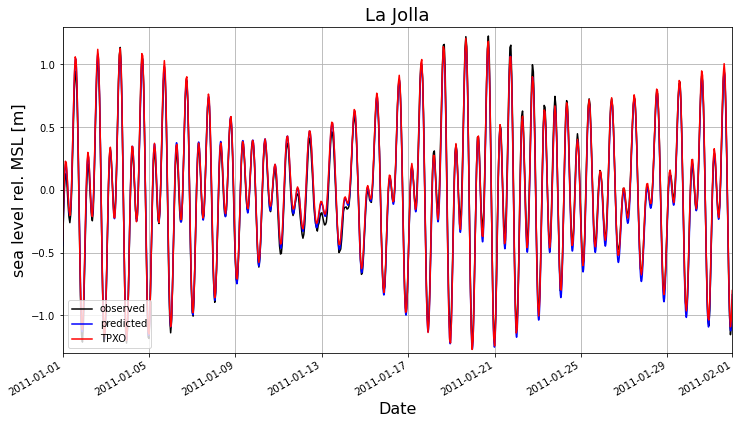

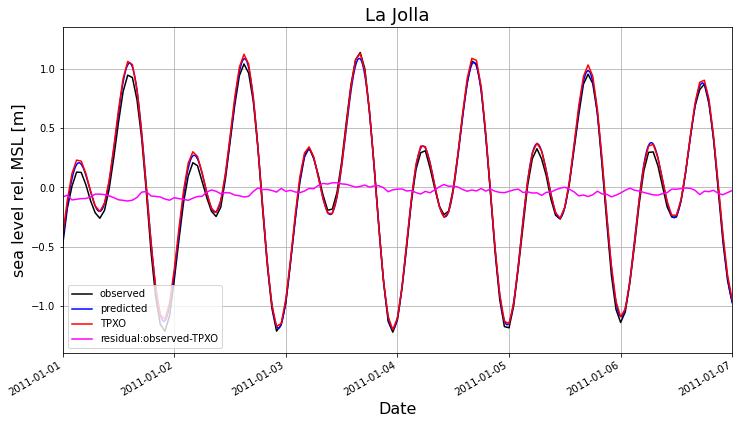

In [8]:
# make time series comparison plot
fig,ax = plt.subplots(figsize=(12, 6))
da_LJ_sl_obs_hourly_short.plot(color='black',label='observed')
da_LJ_sl_pred_6min_short.plot(color='blue',label='predicted')
da_TPXO_LJ_sl_hourly_short.plot(color='red',label='TPXO')
#res_LJ_obs_TPXO_short.plot(color='magenta',label='residual:observed-TPXO')
plt.xlim(dts, dte)
plt.ylim(-1.3,1.3)
plt.xlabel('Date', fontsize=16)
plt.ylabel('sea level rel. MSL [m]', fontsize=16)
plt.title('La Jolla',fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

# zoom in to look at offset
dtzs = np.datetime64('2011-01-01')#'2013-08-01')#'2013-09-08') 
dtze = np.datetime64('2011-01-07')#'2013-08-07')#'2013-09-10')
fig,ax = plt.subplots(figsize=(12, 6))
da_LJ_sl_obs_hourly_short.plot(color='black',label='observed')
da_LJ_sl_pred_6min_short.plot(color='blue',label='predicted')
da_TPXO_LJ_sl_hourly_short.plot(color='red',label='TPXO')
res_LJ_obs_TPXO_short.plot(color='magenta',label='residual:observed-TPXO')
plt.xlim(dtzs, dtze)
#plt.ylim(-1,1)
plt.xlabel('Date', fontsize=16)
plt.ylabel('sea level rel. MSL [m]', fontsize=16)
plt.title('La Jolla',fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)

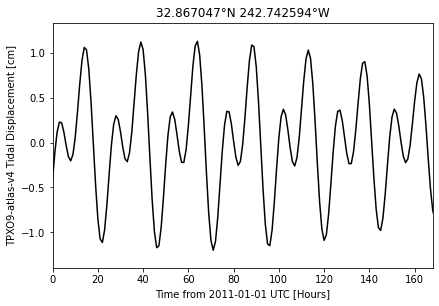

In [9]:
#-- create plot with tidal displacements, high and low tides and dates
fig,ax1 = plt.subplots(num=1)
ax1.plot(hours,TIDE_LJ_hourly_short.data,'k')
ax1.set_xlim(0,7*24)
ax1.set_ylabel('{0} Tidal Displacement [cm]'.format(TIDE_MODEL))
args = (yr_start,mo_start,d_start)
ax1.set_xlabel('Time from {0:4d}-{1:02d}-{2:02d} UTC [Hours]'.format(*args))
ax1.set_title(u'{0:0.6f}\u00b0N {1:0.6f}\u00b0W'.format(LAT,LON))
fig.subplots_adjust(left=0.10,right=0.98,bottom=0.10,top=0.95)
plt.show()
